## Variational autoencoder 변이형 오토 인코더 VAE
- 얼굴을 생성하거나, 기존 이미지를 변경할수도 있다.
- encoding: 의류아이템을 특정위치에 위치시킴
- decoding: 위치를 받아 해당 아이템을 재생성함
- embedding: 그래프내의 아이템을 가리키는 벡터를 의미
- autoencoder: 어떤 항목에대해 인코딩과 디코딩을 수행하도록하는 신경망.
원본 아이템의 임베딩이 없는 위치를 디코딩하여 새로운 아이템을 생성할 수 있다.
=> 생성모델

- 먼저 단순 오토인코더를 만든다.



In [1]:
# 패션 mnist 데이터셋 불러오기
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = \
    datasets.fashion_mnist.load_data()

x_train.shape  #(60000, 28, 28) 픽셀값은 0~ 255 까지이다
y_train.shape  #(60000,)

# 32*32 크기로 조정한다

def preprocess(imgs):
    # 정규화 0~1
    imgs = imgs.astype('float32') / 255.0
    # 패딩 추가
    imgs = np.pad(imgs,((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    # 차원 추가
    imgs = np.expand_dims(imgs, -1)
    return imgs
x_train =preprocess(x_train)
x_train.shape
x_test = preprocess(x_test)

# print(plt.imshow(x_train[0])) 0값으로 패딩만 추가해준것이다


- 인코더: 고차원의 입력 데이터를 저차원 임베딩 벡터z 로 압축
- 디코더: 네트워크를 통해 임베딩벡터를 원본 도메인으로 압축을 푼다(이미지 복원)
- 임베딩 공간(잠재공간 latent space): 임의의 임베딩 포인트를 디코딩하면 새로운 이미지를 생성할 수 있게 된다. 디코더는 임베딩 포인트를 유효한 이미지로 변환하는 방법을 학습하기 때문이다.
 


In [2]:
# 인코더 만들기
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

encoder_input = layers.Input(shape=(32, 32, 1), name = 'encoder_input')

x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')\
    (encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
shape_before_flattening =K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='encoder_output')(x)

encoder = models.Model(encoder_input, encoder_output)

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [3]:
# 디코더 만들기
# 전치합성곱층을 이용해 텐서의 크기를 늘려 다시 이미지의 원래 크기를 얻을수있다

decoder_input = layers.Input(shape = (2,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')\
    (x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu',
                           padding='same',)(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu',
                           padding='same')(x)
decoder_output = layers.Conv2D(1, (3, 3), 
                               strides=1,
                               activation='sigmoid',
                               padding='same',
                               name='decoder_output'
                               )(x)

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [4]:
# 인코더와 디코더 연결
autoencoder = models.Model(encoder_input, decoder(encoder_output))

# 손실함수, 옵티마이저 컴파일
'''
원본이미지와 재구성이미지 픽셀간의 평균제곱근오차 RMSE를 사용해도 된다
대칭적 분포, 비대칭적 손실 분포의 차이이다
'''
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 오토인코더 훈련
autoencoder.fit(
    x_train,
    x_train,
    epochs=3,
    batch_size=120,
    shuffle=True, 
    validation_data=(x_test, x_test),
)


Epoch 1/3
500/500 [==============================] - 101s 195ms/step - loss: 0.3060 - val_loss: 0.2687
Epoch 2/3
500/500 [==============================] - 92s 184ms/step - loss: 0.2639 - val_loss: 0.2617
Epoch 3/3
500/500 [==============================] - 83s 166ms/step - loss: 0.2586 - val_loss: 0.2584


157/157 [==============================] - 4s 21ms/step


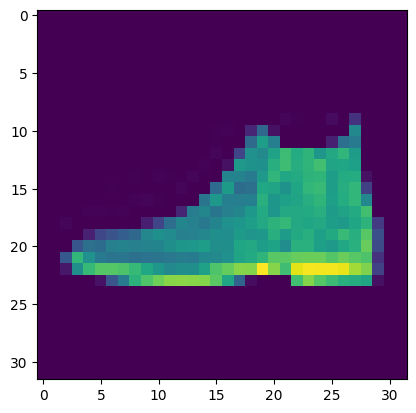

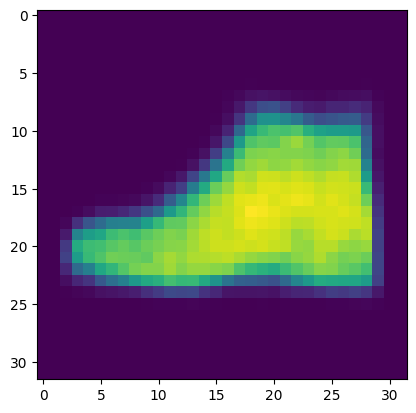

In [5]:
# 이미지가 정확히 재구성되었는지 확인하기
example_imgs = x_test[:5000]
predictions = autoencoder.predict(example_imgs)
plt.imshow(example_imgs[0])
plt.show()
plt.imshow(predictions[0])
plt.show()

157/157 [==============================] - 1s 6ms/step


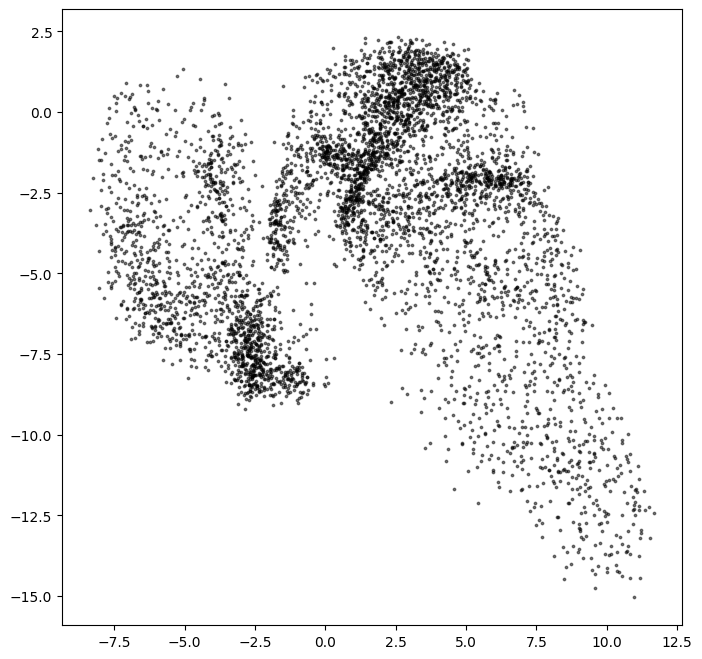

In [6]:
# 잠재공간 시각화
'''
인코더를 통해 만들어진 임베딩을 그래프로 나타내면 잠재공간에 어떻게 
임베딩되는지 시각화 할 수 있다
'''

embeddings = encoder.predict(example_imgs)
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c='black', alpha=0.5, s=3)
plt.show()


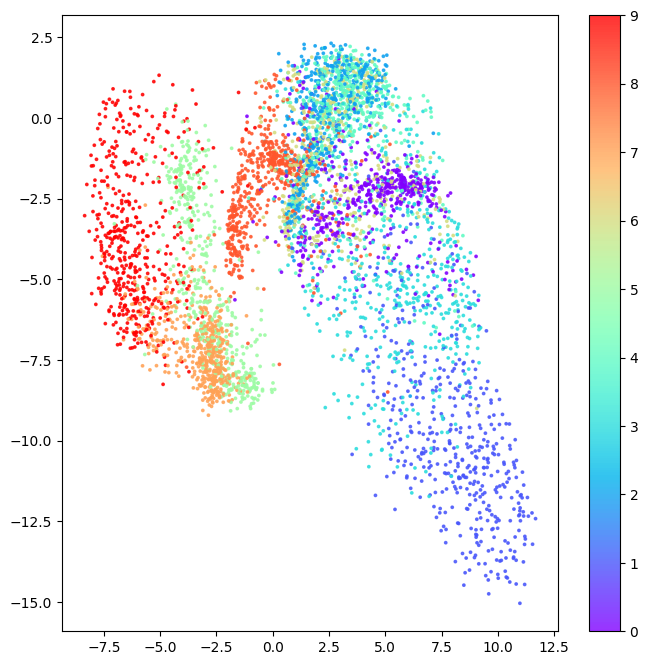

In [7]:
# 컬러 라벨링으로 시각화
example_labels = y_test[:5000]

plt.figure(figsize=(8,8))
plt.scatter(
    embeddings[:,0],
    embeddings[:,1],
    cmap='rainbow',
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [11]:
# 디코더를 사용해 새로운 이미지 생성하기 

# 임베딩은 인코더로 압축한 이미지들의 벡터이다
print(embeddings[0])

# 열을 따라서 벡터 분포의 원소의 최대값 최솟값 벡터를 찾는다.
mins, maxs = np.min(embeddings,axis = 0), np.max(embeddings, axis=0)

# 찾은 최솟값과 최대값 사이에서 랜덤으로 임의의 샘플을 생성한다
# 이때 크기는 18*2 => 18개의 샘플, 성분(열) 2개
sample = np.random.uniform(mins, maxs, size=(18, 2))

# 임의로 생성한 랜덤 샘플을 디코더에 넣어서 
# 새로운 결과물을 만들어 낸다
reconstructions = decoder.predict(sample)


[-4.858311  -5.8665485]
1/1 [==============================] - 0s 66ms/step


AxesImage(shape=(32, 32))


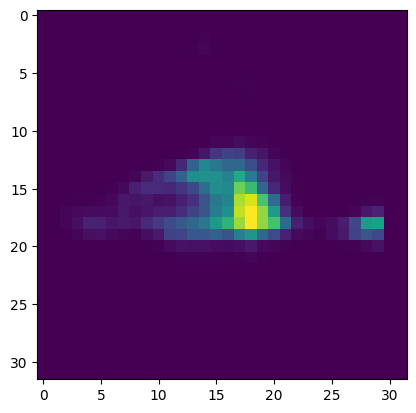

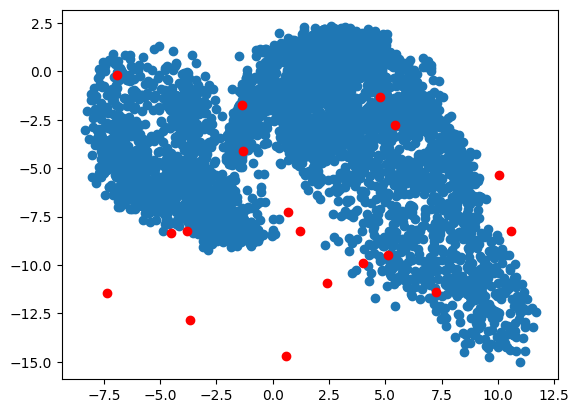

In [38]:
# 결과물을 그려본다
# 랜덤으로 생성된값의 포인트를  latent space 에서 확인해본다
print(plt.imshow(reconstructions[6]))
plt.show()

# print(embeddings[:,0])  # x값만 고름
# print(embeddings[:,1])  # y 값만 고름
plt.scatter(embeddings[:,0], embeddings[:,1])
plt.scatter(sample[:,0], sample[:,1], c='red')
plt.show()


In [45]:
# 일정간격으로 디코딩된 임베딩을 그래피컬하게 출력
# 어렵다.

<Figure size 800x600 with 0 Axes>

## 결론: 단순 오토인코더의 문제점
- 잠재공간에서 임의의 포인트의 디코딩은 애매한 지점에서 더많은 영역의 데이터에 가까운 것으로 디코딩할 가능성이 더높다 => 정확성 부족
- 잠재공간에서 샘플포인트를 어떻게 해야하는지 명확하지않다. 아무곳이나 선택할수있지만 보장 되지않는다.
- 임베딩이 적은 latent space에서의 샘플 포인트는 적절한 아이템을 재구축할수없다.=> 임베딩공간에서의 디코딩은 포인트의 이미지의 연속적인 재구축을 보장하지 않는다. 
#### => 이러한 문제들로 변이형 오토인코더 등장